# Experiment: Feature Manifold Replication in Sentences

## The Problem
Current Interpretability methods often rely on **Attention Heatmaps** to determine if a model is "moving information" from one part of a sentence to another. However, attention can be misleading (e.g., the "Attention Sink" phenomenon).

## The Hypothesis
If a model successfully copies information (e.g., a Date) from a source token to a destination token, the **Feature Manifold** (the geometric shape of that data) should appear at the destination.

## The Experiment
We will use **Supervised Multi-Dimensional Scaling (SMDS)** to detect the presence of a "Date Manifold" (a circular structure) at every single token in a sentence.

**The Pipeline:**
1.  **Generate Data:** Create hundreds of sentences with a fixed structure but varying dates (e.g., *"Alice was born on [Date]..."*).
2.  **Record Activations:** Pass these sentences through an LLM and save the hidden states for every token.
3.  **Apply SMDS:** Test every token position: *Does this token's activation space look like a circle?*

In [1]:
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
import os
import gc
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Import internal tools
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape

%matplotlib inline

# Global Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

def cleanup_gpu():
    """Aggressive memory cleanup to prevent OOM between models."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()

# Define Models to Analyze
# Format: (friendly_name, hf_path, use_quantization)
MODELS_TO_RUN = [
    ("GPT-2", "gpt2", False),
    # ENABLE quantization (True) for 8B models on consumer GPUs
    ("Llama-3.1-8B", "meta-llama/Llama-3.1-8B-Instruct", True),
    ("Qwen-2.5-7B", "Qwen/Qwen2.5-7B-Instruct", True)
]

os.makedirs("data_cache", exist_ok=True)
os.makedirs("results_cache", exist_ok=True)

Running on cuda


## Generate the data

We need a dataset where the **structure is identical** (so token $i$ always corresponds to the same word), but the **content (the date)** changes.

We will generate samples where:
1.  **$X$ (The Input):** A sentence mentioning a birthday.
2.  **$y$ (The Label):** The day of the year (0-365), normalized to $[0, 1]$.

In [2]:
def get_ordinal_date(n):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

def get_day_of_year(month, day):
    """Converts a month/day to a normalized float [0, 1]."""
    date = datetime(2023, month, day)
    day_of_year = date.timetuple().tm_yday - 1
    return day_of_year / 365.0

def generate_dataset(n_samples=1000):
    template = (
        "{Name} was born on the {Day_Ordinal} of {Month}. "
        "{Name} plays volleyball. "
        "{Name}'s favourite color is green. "
        "{Name} lives in Berlin. "
        "{Name} had a party on her birthday."
    )

    months = [
        ("January", 31), ("February", 28), ("March", 31), ("April", 30),
        ("May", 31), ("June", 30), ("July", 31), ("August", 31),
        ("September", 30), ("October", 31), ("November", 30), ("December", 31)
    ]
    names = ["Anna", "Mary", "John", "Paul", "Mark", "Lisa"]

    texts = []
    labels = []

    for _ in range(n_samples):
        name = random.choice(names)
        m_idx = random.randint(0, 11)
        m_name, max_days = months[m_idx]
        day = random.randint(1, max_days)

        y_val = get_day_of_year(m_idx + 1, day)
        day_ord = get_ordinal_date(day)

        text = template.format(Name=name, Day_Ordinal=day_ord, Month=m_name)
        texts.append(text)
        labels.append(y_val)

    return texts, np.array(labels)

# Generate and persist dataset
texts, y_labels = generate_dataset(n_samples=1000)
np.save("data_cache/y_labels.npy", y_labels)
print(f"Generated {len(texts)} samples.")
print(f"Example: {texts[0]}")

Generated 1000 samples.
Example: Lisa was born on the 27th of April. Lisa plays volleyball. Lisa's favourite color is green. Lisa lives in Berlin. Lisa had a party on her birthday.


## Load the model
**Crucial Step:** We must ensure all sentences tokenize to the **exact same length**. If "May" is 1 token and "September" is 1 token, we are fine. If lengths differ, we cannot stack the activations into a simple tensor without padding logic.

Now we perform the extraction. We will define a hook (or simple loop) to grab the hidden states.
We are creating a Tensor **X** of shape `(N_Samples, N_Layers, N_Tokens, Hidden_Dim)`.

*Note: For 1000 samples on GPT2, this fits in RAM. For Llama-70B, you would need to process in batches and save to disk.*

In [3]:
import os
from dotenv import load_dotenv
from huggingface_hub import login

# 1. Load the environment variables
load_dotenv()

# 2. Get the token
hf_token = os.getenv("HF_TOKEN")

if not hf_token:
    raise ValueError("HF_TOKEN not found in .env file! Please create one.")

# 3. Authenticate
# This saves the credential so transformers can find it automatically
login(token=hf_token)

print("Hugging Face Login Successful.")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Hugging Face Login Successful.


In [4]:
def extract_and_cache_activations(friendly_name, model_id, use_quant, texts):
    """
    Loads model, extracts hidden states, and saves to .npz.
    GPT-2 is saved in float32 to preserve outlier features.
    Quantized models are saved in float16 to save space.
    """
    cache_path = f"data_cache/{friendly_name}_activations.npz"
    metadata_path = f"data_cache/{friendly_name}_meta.npz"

    if os.path.exists(cache_path):
        print(f"[{friendly_name}] Activations found in cache. Skipping.")
        return

    cleanup_gpu()
    print(f"[{friendly_name}] Loading Model: {model_id}...")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

    # --- Precision Decision ---
    # GPT-2 needs float32. Quantized Llama/Qwen can use float16.
    storage_dtype = np.float16 if use_quant else np.float32
    print(f"[{friendly_name}] Storage Precision: {storage_dtype}")

    # Dynamic Batch Sizing
    current_batch_size = 4 if use_quant else 32

    try:
        if use_quant:
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,
            )
            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                quantization_config=bnb_config,
                device_map="auto",
                attn_implementation="eager"
            )
        else:
            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                # Ensure base model loads in full precision if space allows
                torch_dtype=torch.float32
            ).to(DEVICE)

        # Determine N Layers
        if hasattr(model.config, "n_layer"): n_layers = model.config.n_layer + 1
        elif hasattr(model.config, "num_hidden_layers"): n_layers = model.config.num_hidden_layers + 1
        else: n_layers = len(model.model.layers) + 1

        # Extraction Loop
        while current_batch_size > 0:
            try:
                print(f"[{friendly_name}] Extracting... (Batch: {current_batch_size})")
                n_samples = inputs['input_ids'].shape[0]
                seq_len = inputs['input_ids'].shape[1]
                hidden_dim = model.config.hidden_size

                # Allocate RAM
                all_acts = np.zeros((n_samples, n_layers, seq_len, hidden_dim), dtype=storage_dtype)

                model.eval()

                with torch.no_grad():
                    for i in range(0, n_samples, current_batch_size):
                        batch_ids = inputs['input_ids'][i:i+current_batch_size].to(model.device)
                        batch_mask = inputs['attention_mask'][i:i+current_batch_size].to(model.device)

                        outputs = model(batch_ids, attention_mask=batch_mask, output_hidden_states=True)

                        # Stack & Convert
                        # Critical: .astype(storage_dtype) happens here
                        batch_acts = torch.stack(outputs.hidden_states).cpu().numpy().astype(storage_dtype)
                        batch_acts = batch_acts.transpose(1, 0, 2, 3)

                        all_acts[i:i+batch_ids.shape[0]] = batch_acts

                        del outputs, batch_ids, batch_mask

                # Success
                print(f"[{friendly_name}] Saving to disk...")
                np.savez_compressed(cache_path, activations=all_acts)

                # Metadata
                sample_ids = inputs['input_ids'][0]
                tokens_str = [tokenizer.decode([tid]).strip() for tid in sample_ids]
                viz_labels = tokenizer.convert_ids_to_tokens(sample_ids)
                np.savez(metadata_path, tokens_str=tokens_str, viz_labels=viz_labels)
                break

            except torch.cuda.OutOfMemoryError:
                current_batch_size //= 2
                print(f"[{friendly_name}] OOM. Retrying with batch {current_batch_size}...")
                cleanup_gpu()
                if current_batch_size == 0: return

    except Exception as e:
        print(f"[{friendly_name}] Error: {e}")
    finally:
        if 'model' in locals(): del model
        if 'tokenizer' in locals(): del tokenizer
        cleanup_gpu()
        print(f"[{friendly_name}] Unloaded.\n")

for name, path, quant in MODELS_TO_RUN:
    extract_and_cache_activations(name, path, quant, texts)

[GPT-2] Activations found in cache. Skipping.
[Llama-3.1-8B] Activations found in cache. Skipping.
[Qwen-2.5-7B] Activations found in cache. Skipping.


In [5]:
def find_token_indices(tokens_str):
    """
    Helper to locate semantic landmarks in the token list.
    """
    months_list = ["january", "february", "march", "april", "may", "june",
                   "july", "august", "september", "october", "november", "december"]

    idx_month = -1
    idx_bday = -1
    idx_distractor = -1

    for i, tok in enumerate(tokens_str):
        # Normalize for case-insensitive matching
        t_low = tok.lower().strip()

        # 1. Find Month (Source)
        if idx_month == -1 and any(m in t_low for m in months_list):
            idx_month = i

        # 2. Find Birthday (Destination)
        if idx_bday == -1 and "birthday" in t_low:
            idx_bday = i

        # 3. Find Distractor
        if idx_distractor == -1 and "volleyball" in t_low:
            idx_distractor = i

    return {
        "Source (Month)": idx_month,
        "Destination (Birthday)": idx_bday,
        "Distractor": idx_distractor
    }

print(">>> Verifying Token Alignments per Model...\n")

model_indices = {}

for name, _, _ in MODELS_TO_RUN:
    # Load metadata cached in Cell 3
    meta_path = f"data_cache/{name}_meta.npz"
    if not os.path.exists(meta_path):
        print(f"[{name}] Metadata not found. Skipping.")
        continue

    meta = np.load(meta_path)
    tokens_str = meta['tokens_str']
    viz_labels = meta['viz_labels']

    # Detect indices
    indices = find_token_indices(tokens_str)
    model_indices[name] = indices

    print(f"[{name}]")
    print(f"  Sample Tokens: {viz_labels[:10]}...")
    print(f"  Detected: {indices}")

    # Print warning if detection failed
    if indices["Source (Month)"] == -1 or indices["Destination (Birthday)"] == -1:
        print("  ⚠️ WARNING: Critical tokens not found! Check tokenizer decoding.")
    print("-" * 60)

>>> Verifying Token Alignments per Model...

[GPT-2]
  Sample Tokens: ['Mark' 'Ġwas' 'Ġborn' 'Ġon' 'Ġthe' 'Ġ7' 'th' 'Ġof' 'ĠDecember' '.']...
  Detected: {'Source (Month)': 8, 'Destination (Birthday)': 32, 'Distractor': 12}
------------------------------------------------------------
[Llama-3.1-8B]
  Sample Tokens: ['<|begin_of_text|>' 'Mark' 'Ġwas' 'Ġborn' 'Ġon' 'Ġthe' 'Ġ' '7' 'th' 'Ġof']...
  Detected: {'Source (Month)': 10, 'Destination (Birthday)': 34, 'Distractor': 14}
------------------------------------------------------------
[Qwen-2.5-7B]
  Sample Tokens: ['Mark' 'Ġwas' 'Ġborn' 'Ġon' 'Ġthe' 'Ġ' '7' 'th' 'Ġof' 'ĠDecember']...
  Detected: {'Source (Month)': 9, 'Destination (Birthday)': 33, 'Distractor': 13}
------------------------------------------------------------


We now have our Data ($X$) and our Manifold Labels ($y$).


In the next phase, we will:
1.  Load the **SMDS** class and **CircularShape** class.
2.  Iterate through every Token Position ($t=0$ to $t=End$).
3.  Run SMDS on `X[:, layer, t, :]` vs `y`.
4.  Plot the resulting Stress curve.

## Experiment 1: Independent Feature Manifold Detection
**The Question:** Does the model construct the "Date" geometry (the circle) at *every* token position?

**The Method:**
We train a **Supervised MDS** projection independently for every token $t$ at every layer $L$.
*   **Input:** Activations $X_{t,L}$ for all 1000 samples.
*   **Target:** The day of the year (circular variable).
*   **Score:** Cross-validated manifold score ($R^2$ or Stress-based).

**Hypothesis:** If the model uses a "global workspace" or smears context, we expect high manifold scores ($>0.8$) to appear on unrelated tokens (like "volleyball") immediately after the date is mentioned.


In [7]:
import os
import gc
import numpy as np
from sklearn.model_selection import KFold
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape
from tqdm import tqdm

def run_experiment_1(friendly_name, y_labels):
    """Computes Independent SMDS scores for all layers/tokens."""
    # Paths
    act_path = f"data_cache/{friendly_name}_activations.npz"
    cache_file = f"results_cache/{friendly_name}_exp1_independent.npy"

    if os.path.exists(cache_file):
        print(f"[{friendly_name}] Exp 1 results found. Loading...")
        return np.load(cache_file)

    if not os.path.exists(act_path):
        print(f"[{friendly_name}] Error: Activations not found. Run extraction first.")
        return None

    # Load Data
    print(f"[{friendly_name}] Loading Activations...")
    data = np.load(act_path)
    X = data['activations'].astype(np.float32) # (N, Layers, Tokens, Dim)

    n_layers, n_tokens = X.shape[1], X.shape[2]
    score_map = np.zeros((n_layers, n_tokens))

    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    print(f"[{friendly_name}] Computing Independent Manifolds...")
    for layer in tqdm(range(n_layers), desc="Layers"):
        for token in range(n_tokens):
            X_loc = X[:, layer, token, :]

            # Skip padding (variance check)
            if np.var(X_loc) < 1e-6: continue

            fold_scores = []
            try:
                for train_ix, test_ix in kf.split(X_loc):
                    # Orthogonal=False allows stretching/skewing (Linear Projection)
                    reducer = SupervisedMDS(stage_1="computed", manifold="circular", orthonormal=False)
                    reducer.fit(X_loc[train_ix], y_labels[train_ix])
                    fold_scores.append(reducer.score(X_loc[test_ix], y_labels[test_ix]))

                score_map[layer, token] = np.mean(fold_scores)
            except:
                score_map[layer, token] = 0.0

    # Cache and Cleanup
    np.save(cache_file, score_map)
    del X, data
    gc.collect()
    return score_map

# Run for all models
exp1_results = {}
for name, _, _ in MODELS_TO_RUN:
    exp1_results[name] = run_experiment_1(name, y_labels)

[GPT-2] Exp 1 results found. Loading...
[Llama-3.1-8B] Exp 1 results found. Loading...
[Qwen-2.5-7B] Exp 1 results found. Loading...


### Visualization

#### We visualize the entire sentence. We look for **vertical bands** (Low Stress) indicating columns where the Date concept is present across many layers.

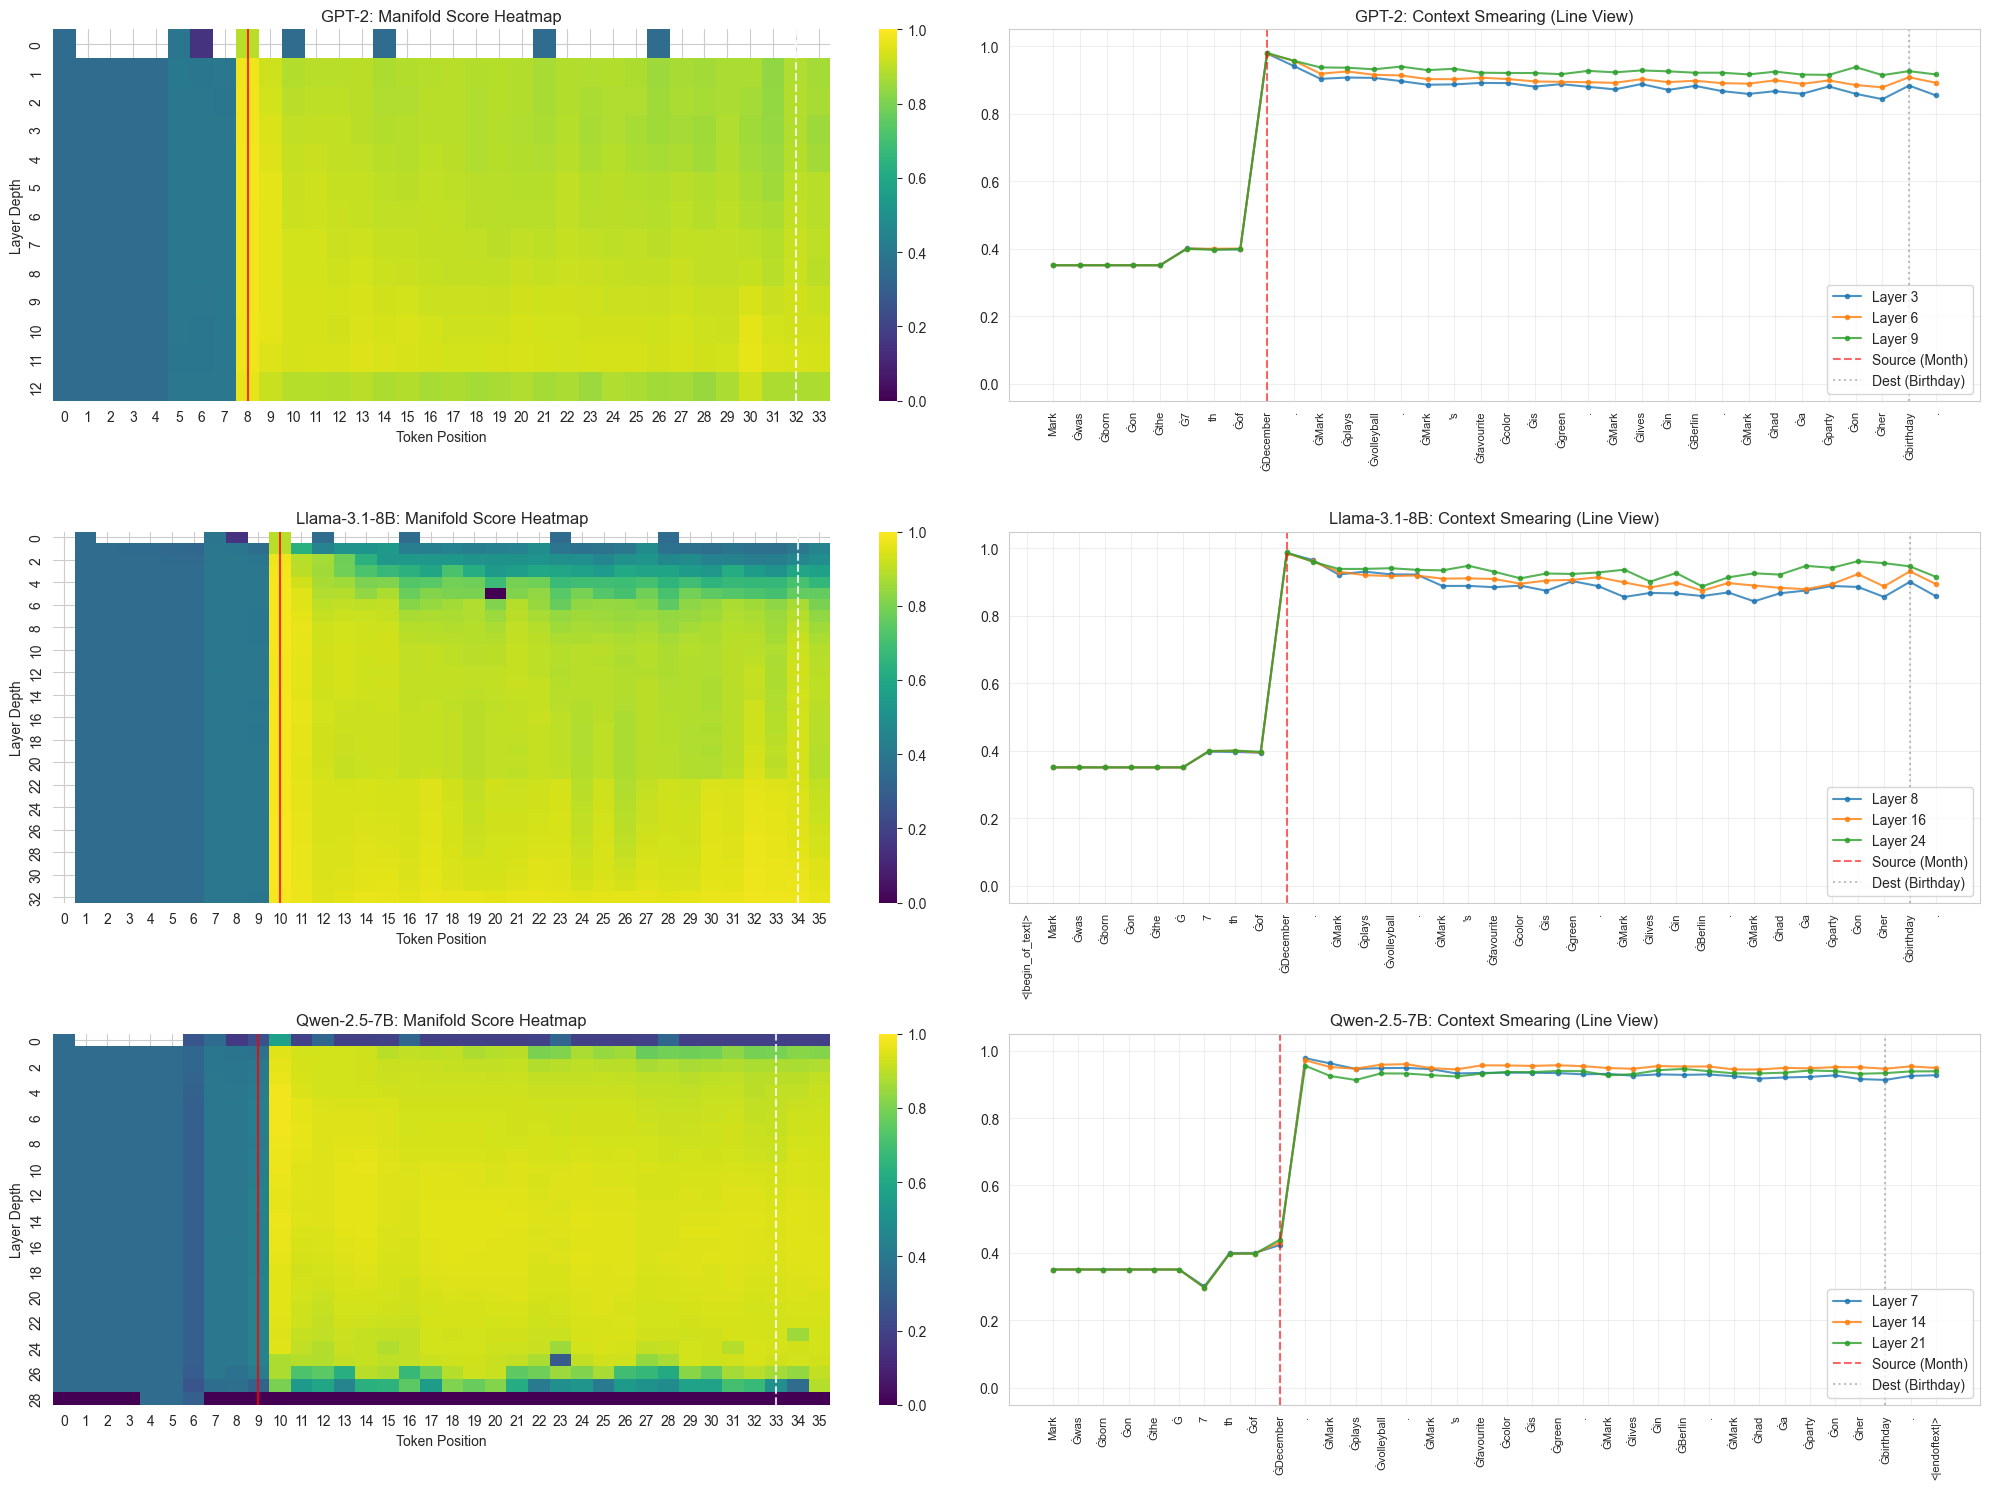

In [19]:
import seaborn as sns

# Create Layout
fig, axes = plt.subplots(len(MODELS_TO_RUN), 2, figsize=(20, 5 * len(MODELS_TO_RUN)))
if len(MODELS_TO_RUN) == 1: axes = axes.reshape(1, -1)

for i, (name, _, _) in enumerate(MODELS_TO_RUN):
    # Load Data
    scores = exp1_results[name]
    meta = np.load(f"data_cache/{name}_meta.npz")
    viz_labels = meta['viz_labels']

    # Get Indices (Source: Month, Dest: Birthday) from Cell 3.5
    indices = model_indices.get(name, {})
    src_idx = indices.get("Source (Month)", -1)
    dest_idx = indices.get("Destination (Birthday)", -1)

    # --- 1. Heatmap (Left Column) ---
    sns.heatmap(scores, cmap="viridis", vmin=0, vmax=1, ax=axes[i,0], cbar=True)
    axes[i,0].set_title(f"{name}: Manifold Score Heatmap")
    axes[i,0].set_ylabel("Layer Depth")
    axes[i,0].set_xlabel("Token Position")

    # Add Markers to Heatmap
    if src_idx != -1:
        axes[i,0].axvline(src_idx + 0.5, color='red', linestyle='-', linewidth=1.5, alpha=0.8)
    if dest_idx != -1:
        axes[i,0].axvline(dest_idx + 0.5, color='white', linestyle='--', linewidth=1.5, alpha=0.8)

    # --- 2. Line Plots (Right Column) ---
    # Select representative layers: Early (25%), Middle (50%), Late (75%)
    n_layers = scores.shape[0]
    target_layers = [int(n_layers*0.25), int(n_layers*0.50), int(n_layers*0.75)]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

    for j, lay_idx in enumerate(target_layers):
        score_line = scores[lay_idx, :]
        axes[i,1].plot(score_line, label=f"Layer {lay_idx}", color=colors[j], marker='.', alpha=0.8)

    # Add Markers to Line Plot
    if src_idx != -1:
        axes[i,1].axvline(src_idx, color='red', linestyle='--', alpha=0.6, label="Source (Month)")
    if dest_idx != -1:
        axes[i,1].axvline(dest_idx, color='gray', linestyle=':', alpha=0.5, label="Dest (Birthday)")

    # Styling
    axes[i,1].set_title(f"{name}: Context Smearing (Line View)")
    axes[i,1].set_ylim(-0.05, 1.05)

    # X-Ticks (Tokens)
    axes[i,1].set_xticks(np.arange(len(viz_labels)))
    axes[i,1].set_xticklabels(viz_labels, rotation=90, fontsize=8)

    axes[i,1].grid(True, alpha=0.3)
    axes[i,1].legend(loc='lower right')

plt.tight_layout()
plt.show()

## Experiment 2: Subspace Similarity ($W$-Matrix Comparison)
**The Question:** Is the "Date Circle" stored in the *same* linear subspace at every token, or does the model rotate the representation as it processes the sentence?

**The Method:**
1.  For a specific deep layer (where we saw high scores in Exp 1), we compute the projection matrix $W_t$ for every token $t$.
2.  We calculate the pairwise **Cosine Similarity** between the flattened matrices $W_i$ and $W_j$.

**Interpretation:**
*   **High Similarity (Red):** The subspace is stable (the "Date" direction doesn't change).
*   **Low Similarity (Blue):** The model has rotated or transformed the representation, even if the geometry (the circle) is preserved.

In [14]:
def compute_experiment_2(friendly_name, y_labels, layer_fraction=0.6):
    """
    Computes pairwise W-matrix cosine similarity for a specific deep layer.
    """
    cache_file = f"results_cache/{friendly_name}_exp2_similarity.npy"
    act_path = f"data_cache/{friendly_name}_activations.npz"

    if os.path.exists(cache_file):
        print(f"[{friendly_name}] Exp 2 results found. Loading...")
        return np.load(cache_file)

    print(f"[{friendly_name}] Computing Subspace Similarity...")

    # Load Data
    data = np.load(act_path)
    X_full = data['activations']

    # Select layer
    target_layer = int(X_full.shape[1] * layer_fraction)
    # Ensure valid layer index
    target_layer = min(target_layer, X_full.shape[1] - 2)

    X_layer = X_full[:, target_layer, :, :].astype(np.float32)
    n_tokens = X_layer.shape[1]

    # 1. Train W for every token
    Ws = []

    for t in range(n_tokens):
        X_tok = X_layer[:, t, :]

        # Skip padding
        if np.var(X_tok) < 1e-6:
            Ws.append(None)
            continue

        try:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_tok)
            reducer = SupervisedMDS(manifold="circular")
            reducer.fit(X_scaled, y_labels)
            Ws.append(reducer.W_.flatten())
        except:
            Ws.append(None)

    # 2. Compute Similarity Matrix
    sim_matrix = np.zeros((n_tokens, n_tokens))
    for i in range(n_tokens):
        for j in range(n_tokens):
            if Ws[i] is None or Ws[j] is None:
                continue

            # Abs cosine sim (ignore sign flips)
            sim = abs(cosine_similarity(Ws[i].reshape(1,-1), Ws[j].reshape(1,-1))[0,0])
            sim_matrix[i, j] = sim

    np.save(cache_file, sim_matrix)

    # Cleanup
    del X_full, X_layer
    gc.collect()
    return sim_matrix

exp2_results = {}
for name, _, _ in MODELS_TO_RUN:
    exp2_results[name] = compute_experiment_2(name, y_labels)

[GPT-2] Computing Subspace Similarity...
[Llama-3.1-8B] Computing Subspace Similarity...
[Qwen-2.5-7B] Computing Subspace Similarity...


### Visualization

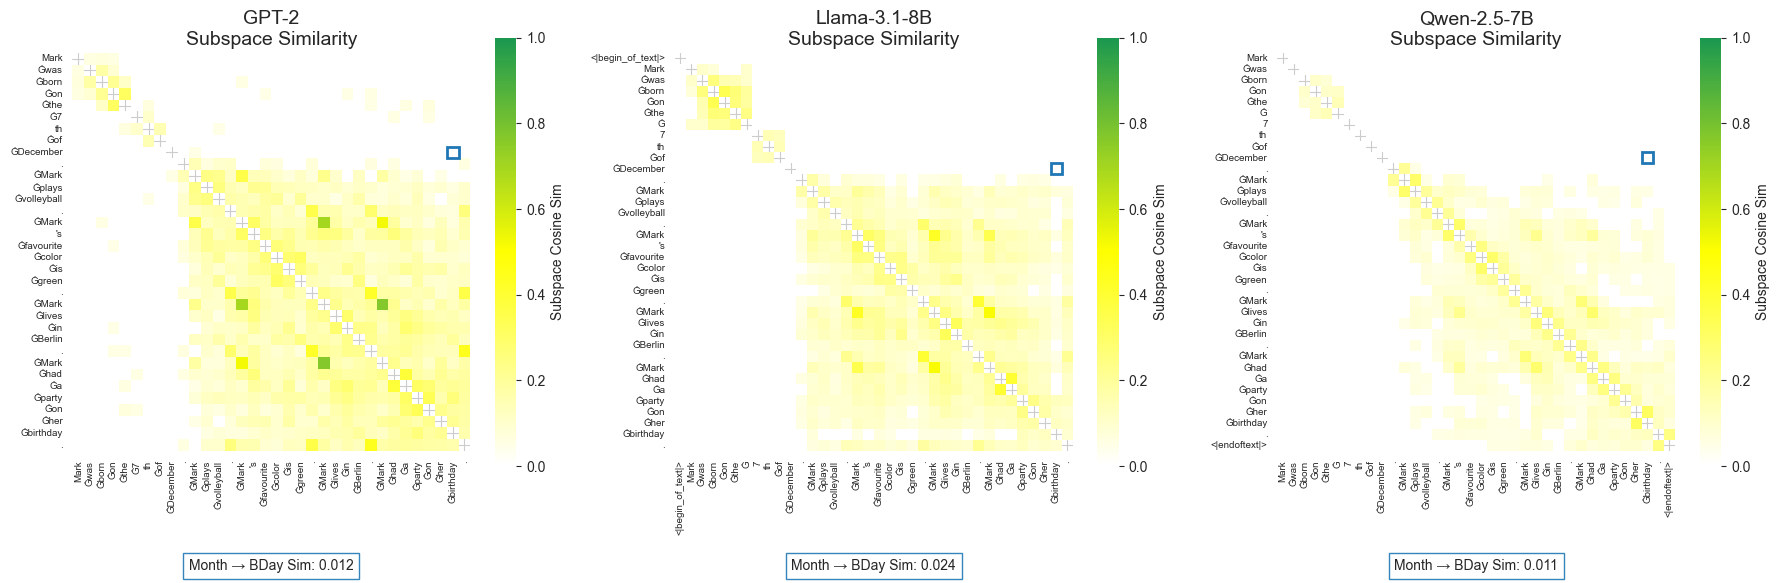

In [21]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

# Define Custom Colormap (White -> Green)
# Adjusted to show high similarity clearly
ryg = LinearSegmentedColormap.from_list("custom_sim", ["#FFFFFF", "#fff7bc", "#fec44f", "#d95f0e", "#e31a1c", "#800026"]) # White to Dark Red (Heat)
# Or sticking to your Red-Yellow-Green:
ryg = LinearSegmentedColormap.from_list("ryg", [(0.0, "#FFFFFF"), (0.5, "#FFFF00"), (1.0, "#1a9850")])

fig, axes = plt.subplots(1, len(MODELS_TO_RUN), figsize=(6 * len(MODELS_TO_RUN), 6))
if len(MODELS_TO_RUN) == 1: axes = [axes]

for i, (name, _, _) in enumerate(MODELS_TO_RUN):
    sim_matrix = exp2_results[name]
    meta = np.load(f"data_cache/{name}_meta.npz")
    viz_labels = meta['viz_labels']

    # Mask diagonal (self-similarity is always 1.0)
    mask = np.eye(sim_matrix.shape[0], dtype=bool)

    # Filter noise
    plot_matrix = sim_matrix.copy()
    plot_matrix[plot_matrix < 0.05] = 0.0

    # Heatmap
    sns.heatmap(
        plot_matrix,
        mask=mask,
        xticklabels=viz_labels,
        yticklabels=viz_labels,
        cmap=ryg,
        vmin=0, vmax=1,
        square=True,
        cbar=True,
        cbar_kws={'label': 'Subspace Cosine Sim', 'shrink': 0.8},
        ax=axes[i]
    )

    axes[i].set_title(f"{name}\nSubspace Similarity", fontsize=14)
    axes[i].tick_params(axis='x', rotation=90, labelsize=7)
    axes[i].tick_params(axis='y', rotation=0, labelsize=7)

    # --- Highlight Source -> Dest Interaction ---
    indices = model_indices[name]
    idx_src = indices["Source (Month)"]
    idx_dest = indices["Destination (Birthday)"]

    if idx_src != -1 and idx_dest != -1:
        # Draw Box
        rect = Rectangle(
            (idx_dest, idx_src), 1, 1,
            fill=False, edgecolor="#1f77b4", lw=2, zorder=10
        )
        axes[i].add_patch(rect)

        # Annotate Score
        score = sim_matrix[idx_src, idx_dest]
        axes[i].text(
            0.5, -0.3,
            f"Month → BDay Sim: {score:.3f}",
            transform=axes[i].transAxes,
            fontsize=10, ha='center',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor="#1f77b4")
        )

plt.tight_layout()
plt.show()

## Experiment 3: Subspace Reuse (One-Shot Projection)
**The Question:** Can we train a probe on the "Month" token and successfully decode the "Birthday" token?

**The Method:**
1.  **Train:** Learn $W_{source}$ on the Source Token (Month).
2.  **Apply:** Freeze $W_{source}$ and apply it to all other tokens $X_{target}$.
3.  **Score:** Measure how well this *frozen* projection retrieves the date.

**Interpretation:**
This verifies Experiment 2. If Exp 2 showed low similarity (rotation), this experiment should fail (low scores), proving that the model does **not** simply copy-paste the information vector.

In [25]:
def run_experiment_3(friendly_name, y_labels):
    act_path = f"data_cache/{friendly_name}_activations.npz"
    meta_path = f"data_cache/{friendly_name}_meta.npz"
    cache_file = f"results_cache/{friendly_name}_exp3_reuse.npy"

    if os.path.exists(cache_file):
        print(f"[{friendly_name}] Exp 3 results found. Loading...")
        return np.load(cache_file)

    # Load Data
    data = np.load(act_path)
    X = data['activations'].astype(np.float32)
    meta = np.load(meta_path)
    tokens_str = meta['tokens_str']

    # Robust Source Finding
    months_list = ["january", "february", "march", "april", "may", "june",
                   "july", "august", "september", "october", "november", "december"]

    src_idx = -1
    for i, t in enumerate(tokens_str):
        # Clean up token string: remove special chars (like Ġ or  ) and lower
        clean_t = t.lower().replace('ġ', '').replace(' ', '').strip()

        # Check against months
        if clean_t in months_list:
            src_idx = i
            break
        # Fallback: substring match if token is like "April," or " April"
        if any(m == clean_t for m in months_list):
             src_idx = i
             break

    # Still not found? Try broader search
    if src_idx == -1:
        src_idx = next((i for i, t in enumerate(tokens_str) if any(m in t.lower() for m in months_list)), -1)

    if src_idx == -1:
        print(f"[{friendly_name}] CRITICAL: Month token NOT found in: {tokens_str}")
        return np.zeros((X.shape[1], X.shape[2]))

    print(f"[{friendly_name}] Training Reuse Projector on index {src_idx} ('{tokens_str[src_idx]}')...")

    n_layers, n_tokens = X.shape[1], X.shape[2]
    reuse_map = np.zeros((n_layers, n_tokens))

    for layer in tqdm(range(n_layers), desc="Reuse Layers"):
        # 1. Fit Source
        X_src = X[:, layer, src_idx, :]
        if np.var(X_src) < 1e-6: continue

        # Source-specific scaler
        scaler_src = StandardScaler()
        X_src_norm = scaler_src.fit_transform(X_src)

        projector = SupervisedMDS(manifold="circular")
        try:
            projector.fit(X_src_norm, y_labels)
        except:
            continue

        # 2. Apply to ALL Targets
        for token in range(n_tokens):
            X_tgt = X[:, layer, token, :]
            if np.var(X_tgt) < 1e-6: continue

            # Targets must be scaled by their OWN stats (StandardScaler is token-independent)
            # but projected by the SOURCE's W matrix
            scaler_tgt = StandardScaler()
            X_tgt_norm = scaler_tgt.fit_transform(X_tgt)

            try:
                score = projector.score(X_tgt_norm, y_labels)
                reuse_map[layer, token] = max(0.0, min(1.0, score))
            except:
                pass

    np.save(cache_file, reuse_map)
    del X
    gc.collect()
    return reuse_map

exp3_results = {}
for name, _, _ in MODELS_TO_RUN:
    exp3_results[name] = run_experiment_3(name, y_labels)

[GPT-2] Training Reuse Projector on index 8 ('December')...


Reuse Layers: 100%|██████████| 13/13 [00:14<00:00,  1.09s/it]


[Llama-3.1-8B] Training Reuse Projector on index 10 ('December')...


Reuse Layers: 100%|██████████| 33/33 [01:49<00:00,  3.32s/it]


[Qwen-2.5-7B] Training Reuse Projector on index 9 ('December')...


Reuse Layers: 100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


### Visualization


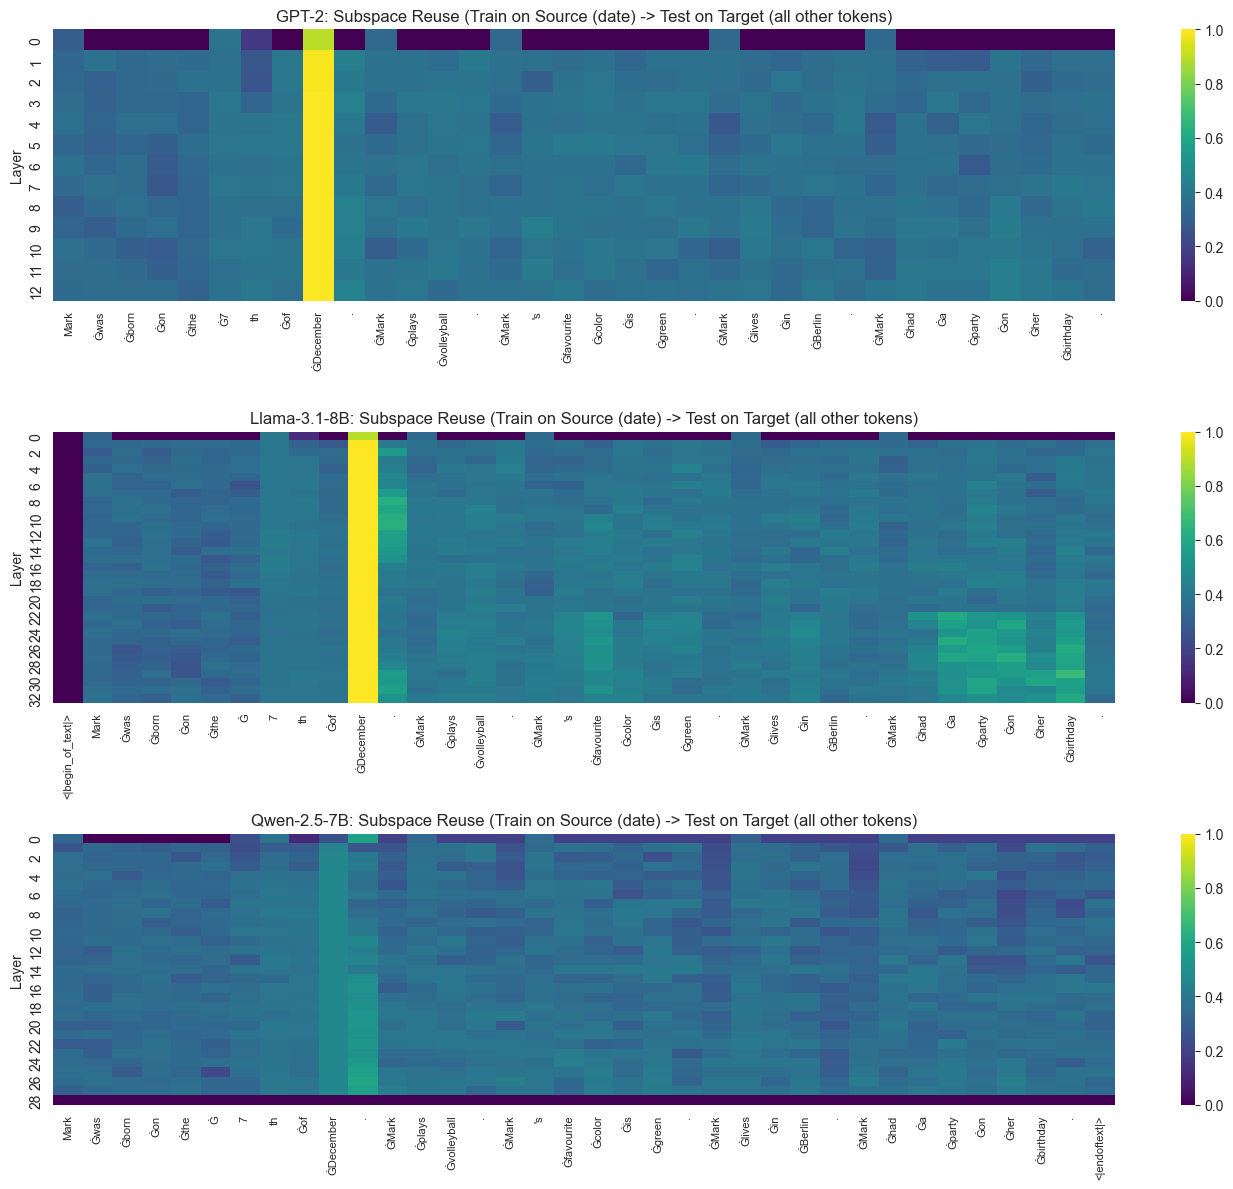

In [27]:
fig, axes = plt.subplots(len(MODELS_TO_RUN), 1, figsize=(14, 4 * len(MODELS_TO_RUN)))
if len(MODELS_TO_RUN) == 1: axes = [axes]

for i, (name, _, _) in enumerate(MODELS_TO_RUN):
    data = exp3_results[name]
    meta = np.load(f"data_cache/{name}_meta.npz")
    viz_labels = meta['viz_labels']

    sns.heatmap(data, cmap="viridis", vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(f"{name}: Subspace Reuse (Train on Source (date) -> Test on Target (all other tokens)")
    axes[i].set_ylabel("Layer")
    axes[i].set_xticks(np.arange(len(viz_labels)) + 0.5)
    axes[i].set_xticklabels(viz_labels, rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Hypothoses for lower score on date token itself for Qwen

Qwen might have extremely spiky activations (outliers) that vary slightly due to floating point quantization artifacts (4-bit quantized and saved as float16). Hence the scaling parameters (mean/std) might drift slightly, causing the projection to misalign just enough to drop the score.

## Experiment 4: Rigid Geometry Check (Orthonormal SMDS)
**The Question:** Is the feature manifold a *perfect* circle, or a *distorted* circle?

**The Method:**
We re-run Experiment 1 but force the projection matrix $W$ to be **Orthonormal** ($W^T W = I$). This allows rotation but prevents stretching or shearing.

**Interpretation:**
*   **Score Drops (vs Exp 1):** The manifold is distorted (stretched). The model represents the date as an ellipse or skewed shape, not a perfect circle.
*   **Score Stays High:** The manifold is a pristine, rigid circle.

In [9]:
import tqdm

def compute_experiment_4(friendly_name, y_labels):
    """
    Computes Orthonormal SMDS scores.
    This tests if the manifold is a RIGID circle (no stretching allowed).
    """
    cache_file = f"results_cache/{friendly_name}_exp4_ortho.npy"
    act_path = f"data_cache/{friendly_name}_activations.npz"

    if os.path.exists(cache_file):
        print(f"[{friendly_name}] Exp 4 results found. Loading...")
        return np.load(cache_file)

    print(f"[{friendly_name}] Computing Orthonormal SMDS (Rigid Constraint)...")

    # Load Data
    data = np.load(act_path)
    X = data['activations'].astype(np.float32)
    n_layers, n_tokens = X.shape[1], X.shape[2]

    scores = np.zeros((n_layers, n_tokens))
    shape = CircularShape()

    # Simple 80/20 split for speed (Orthonormal is usually faster but robust)
    split_idx = int(0.8 * X.shape[0])

    for layer in tqdm.tqdm(range(n_layers), desc="Ortho Layers"):
        for token in range(n_tokens):
            X_loc = X[:, layer, token, :]

            # Skip padding
            if np.var(X_loc) < 1e-6: continue

            # Apply Scaling (Critical for GPT-2)
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_loc)

            try:
                # Constraint: orthonormal=True
                reducer = SupervisedMDS(manifold="circular", orthonormal=True, alpha=0)

                # Train on 80%
                reducer.fit(X_scaled[:split_idx], y_labels[:split_idx])

                # Test on 20%
                s = reducer.score(X_scaled[split_idx:], y_labels[split_idx:])
                scores[layer, token] = max(0.0, min(1.0, s))
            except:
                pass

    np.save(cache_file, scores)
    del X
    gc.collect()
    return scores

exp4_results = {}
for name, _, _ in MODELS_TO_RUN:
    exp4_results[name] = compute_experiment_4(name, y_labels)

[GPT-2] Exp 4 results found. Loading...
[Llama-3.1-8B] Computing Orthonormal SMDS (Rigid Constraint)...


Ortho Layers: 100%|██████████| 33/33 [01:43<00:00,  3.14s/it]


[Qwen-2.5-7B] Computing Orthonormal SMDS (Rigid Constraint)...


Ortho Layers: 100%|██████████| 29/29 [01:24<00:00,  2.91s/it]


### Visualization

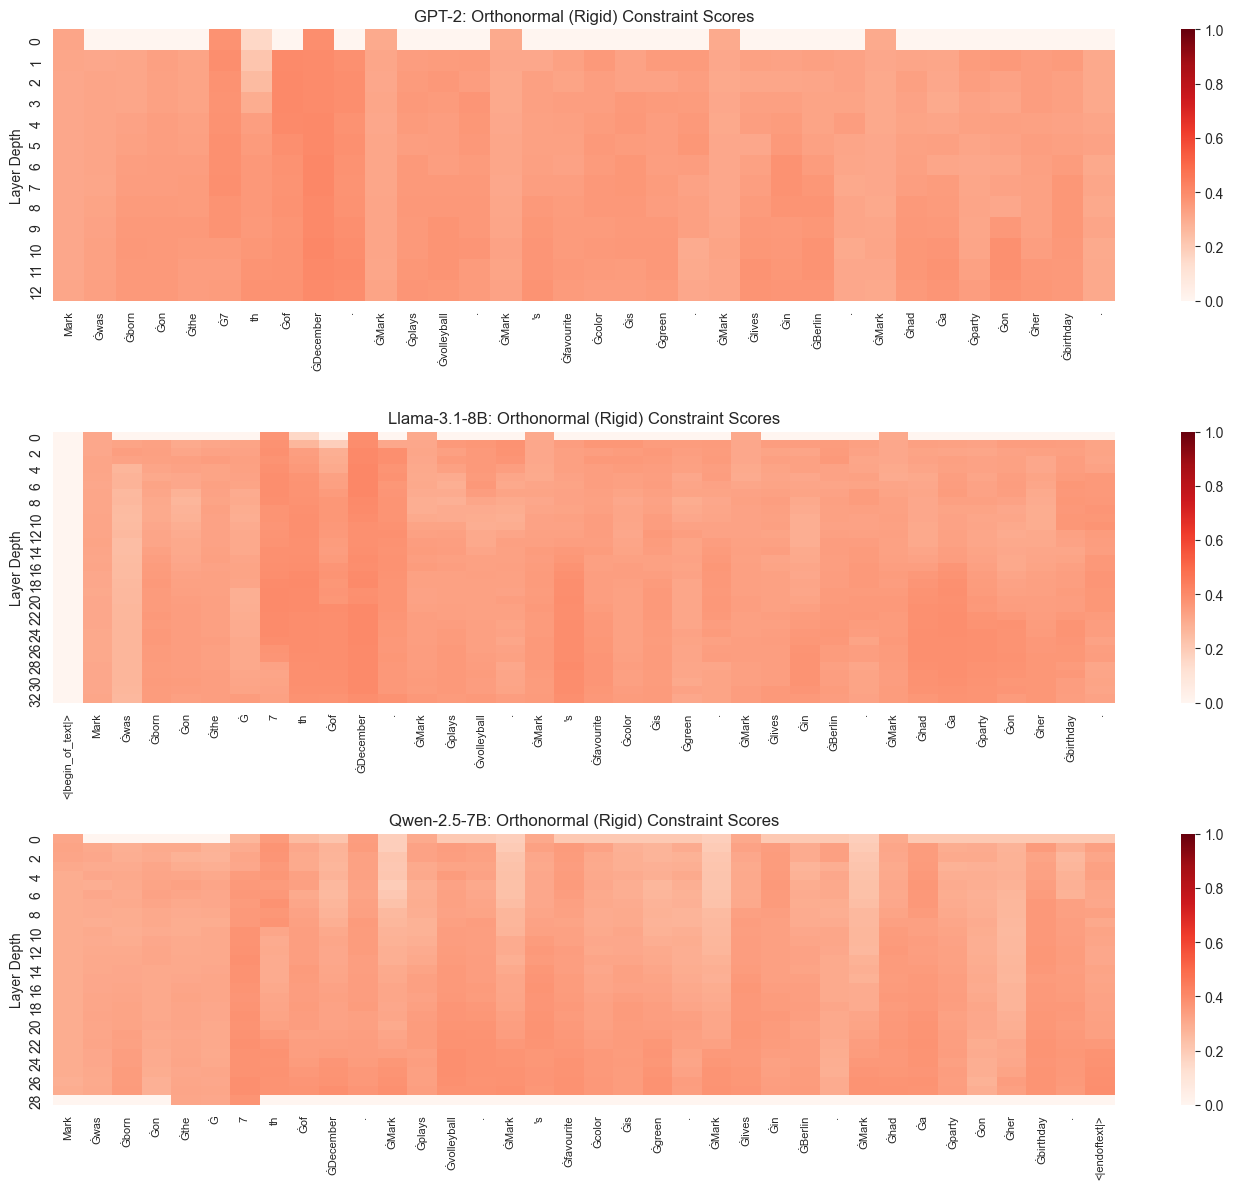

In [10]:
fig, axes = plt.subplots(len(MODELS_TO_RUN), 1, figsize=(14, 4 * len(MODELS_TO_RUN)))
if len(MODELS_TO_RUN) == 1: axes = [axes]

for i, (name, _, _) in enumerate(MODELS_TO_RUN):
    # Load Data
    ortho_map = exp4_results[name]
    meta = np.load(f"data_cache/{name}_meta.npz")
    viz_labels = meta['viz_labels']

    # Plot
    sns.heatmap(ortho_map, cmap="Reds", vmin=0, vmax=1, ax=axes[i])

    axes[i].set_title(f"{name}: Orthonormal (Rigid) Constraint Scores")
    axes[i].set_ylabel("Layer Depth")

    # X-Axis Labels
    axes[i].set_xticks(np.arange(len(viz_labels)) + 0.5)
    axes[i].set_xticklabels(viz_labels, rotation=90, fontsize=8)

plt.tight_layout()
plt.show()